In [286]:

import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sn
from matplotlib import pyplot as plt 
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras

In [287]:
def reformat_dt(dt):
    dt['row_date'] = dt['row_date'].str[:-3]
    dt[['any','mes','dia']]=dt['row_date'].str.split("-",expand=True)
    dt[['dia','hora']]=dt['dia'].str.split(" ",expand=True)
    dt[['hora','minuts']]=dt['hora'].str.split(":",expand=True)
    for st in ['hora','dia','mes','minuts','any']:
        dt[st] = dt[st].astype(int)
    
    return dt

In [288]:
def reformat_file(filepath:str):
    return reformat_dt(pd.read_csv(filepath))

In [289]:
amoni = reformat_file("dataset/amoni.csv")
water = reformat_file("dataset/aigua.csv")
air = reformat_file("dataset/aire.csv")

In [290]:

#INNER JOINS DE ELS TRES FITXERS SOBRE LA DADA ROW_DATE

result = amoni.set_index('row_date').join(water.set_index('row_date'),lsuffix= "_amoni",rsuffix="_water",how = "inner")
result = result.join(air.set_index('row_date'),how = "inner")
result = result[["value_amoni","value_water","value","any","mes","dia","hora","minuts","is_drift","dangerous_drift"]]
result["n"] = result.select_dtypes("bool").sum(axis=1)
result.drop("is_drift",axis =1)
result.drop("dangerous_drift",axis =1)
#MESCLEM LES DADES PER ALS INPUTS
res_len = len(result.index)



In [291]:
amoni

,row_date,value,is_drift,dangerous_drift,any,mes,dia,hora,minuts
0,2020-01-01 00:00,0.128210,False,False,2020,1,1,0,0
1,2020-01-01 00:01,0.148954,False,False,2020,1,1,0,1
2,2020-01-01 00:02,0.148954,False,False,2020,1,1,0,2
3,2020-01-01 00:03,0.159326,False,False,2020,1,1,0,3
4,2020-01-01 00:04,0.159326,False,False,2020,1,1,0,4
...,...,...,...,...,...,...,...,...,...
228879,2020-06-22 11:19,-0.784526,False,False,2020,6,22,11,19
228880,2020-06-22 11:20,-0.789712,False,False,2020,6,22,11,20
228881,2020-06-22 11:21,-0.784526,False,False,2020,6,22,11,21
228882,2020-06-22 11:22,-0.784526,False,False,2020,6,22,11,22


In [292]:
air

,row_date,value,any,mes,dia,hora,minuts
0,2020-06-18 00:00,-1.767678,2020,6,18,0,0
1,2020-06-18 00:01,-1.787435,2020,6,18,0,1
2,2020-06-18 00:02,-1.858639,2020,6,18,0,2
3,2020-06-18 00:03,-1.800194,2020,6,18,0,3
4,2020-06-18 00:04,-1.748334,2020,6,18,0,4
...,...,...,...,...,...,...,...
481060,2021-05-26 23:55,0.950031,2021,5,26,23,55
481061,2021-05-26 23:56,0.813384,2021,5,26,23,56
481062,2021-05-26 23:57,0.852485,2021,5,26,23,57
481063,2021-05-26 23:58,0.800625,2021,5,26,23,58


In [293]:
water

,row_date,value,any,mes,dia,hora,minuts
0,2020-06-18 00:00,-0.314054,2020,6,18,0,0
1,2020-06-18 00:01,-0.255036,2020,6,18,0,1
2,2020-06-18 00:02,-0.242324,2020,6,18,0,2
3,2020-06-18 00:03,-0.271833,2020,6,18,0,3
4,2020-06-18 00:04,-0.221441,2020,6,18,0,4
...,...,...,...,...,...,...,...
481065,2021-05-26 23:55,0.958925,2021,5,26,23,55
481066,2021-05-26 23:56,0.921244,2021,5,26,23,56
481067,2021-05-26 23:57,0.929416,2021,5,26,23,57
481068,2021-05-26 23:58,1.103293,2021,5,26,23,58


In [294]:
#NORMALITZEM DADES:

cols_to_norm = ['value_amoni','value_water','value','dia','hora','minuts']
result_nn = result.copy()
result_nn[cols_to_norm]= result_nn[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
result_nn['mes'] = result['mes'].apply(lambda x: (x) / 12)
result_nn = result_nn.drop("dangerous_drift",axis =1)
result_nn = result_nn.drop("is_drift",axis=1)
result_nn = result_nn.drop("any",axis=1)


<AxesSubplot:>

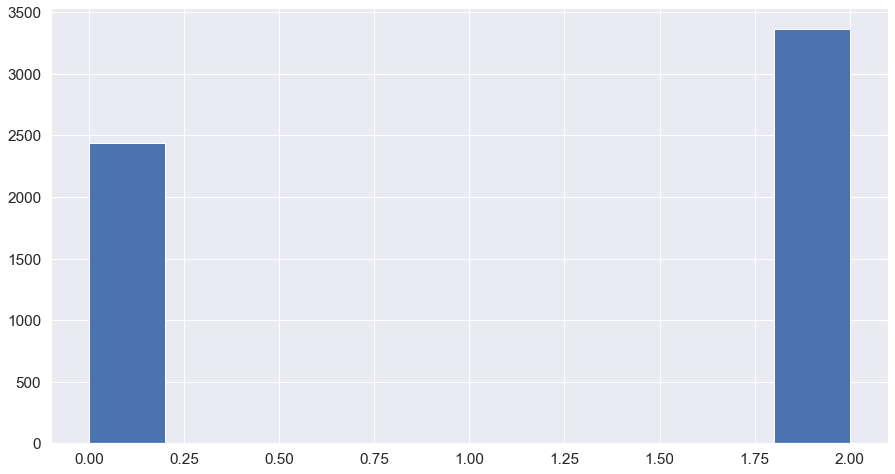

In [295]:
result_nn.n.hist()

In [296]:
result_nn[result_nn.n==2] =1

In [297]:
result_nn

,value_amoni,value_water,value,mes,dia,hora,minuts,n
row_date,,,,,,,,
2020-06-18 00:00,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1
2020-06-18 00:01,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1
2020-06-18 00:02,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1
2020-06-18 00:03,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1
2020-06-18 00:04,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...
2020-06-22 11:19,0.070621,0.457691,0.355765,0.5,1.0,0.478261,0.322034,0
2020-06-22 11:20,0.069209,0.439679,0.333915,0.5,1.0,0.478261,0.338983,0
2020-06-22 11:21,0.070621,0.468576,0.475687,0.5,1.0,0.478261,0.355932,0


In [298]:
model = keras.Sequential([
    keras.layers.Dense(7,input_shape =(7,)),  # input layer (1)
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.Dense(200, activation='sigmoid'), 
    keras.layers.Dense(100, activation='sigmoid'), # hidden layer (2)
    keras.layers.Dense(1, activation='sigmoid') # output layer (3)
])

In [299]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
        

In [300]:
train_model_nn,test_model_nn = train_test_split(result_nn,test_size =0.2)

In [301]:
train_model_nn

,value_amoni,value_water,value,mes,dia,hora,minuts,n
row_date,,,,,,,,
2020-06-18 09:39,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1
2020-06-19 13:43,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1
2020-06-19 22:54,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1
2020-06-22 00:58,0.696328,0.442011,0.215531,0.5,1.0,0.00000,0.983051,0
2020-06-18 18:51,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1
...,...,...,...,...,...,...,...,...
2020-06-22 06:29,0.271186,0.158093,0.087505,0.5,1.0,0.26087,0.491525,0
2020-06-19 19:20,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1
2020-06-18 14:06,1.000000,1.000000,1.000000,1.0,1.0,1.00000,1.000000,1


In [302]:
test_model_nn

,value_amoni,value_water,value,mes,dia,hora,minuts,n
row_date,,,,,,,,
2020-06-19 20:25,1.000000,1.000000,1.000000,1.0,1.00,1.000000,1.000000,1
2020-06-18 17:36,1.000000,1.000000,1.000000,1.0,1.00,1.000000,1.000000,1
2020-06-22 05:53,0.353107,0.152132,0.815962,0.5,1.00,0.217391,0.898305,0
2020-06-20 06:53,1.000000,1.000000,1.000000,1.0,1.00,1.000000,1.000000,1
2020-06-21 08:40,0.046610,0.200467,0.113459,0.5,0.75,0.347826,0.677966,0
...,...,...,...,...,...,...,...,...
2020-06-20 19:06,0.385593,0.927433,0.675010,0.5,0.50,0.826087,0.101695,0
2020-06-20 20:14,0.344633,0.851367,0.426241,0.5,0.50,0.869565,0.237288,0
2020-06-20 00:46,1.000000,1.000000,1.000000,1.0,1.00,1.000000,1.000000,1


In [303]:
col = "n"
test_nn_X = test_model_nn.loc[:,test_model_nn.columns!=col]
test_nn_y = test_model_nn[[col]]
train_nn_X = train_model_nn.loc[:,train_model_nn.columns!=col]
train_nn_y = train_model_nn[[col]]

In [304]:
model.fit(train_nn_X, train_nn_y, epochs=20,validation_data=(test_nn_X,test_nn_y)) 

Epoch 1/20
145/145 [==============================] - 1s 4ms/step - loss: 0.4773 - accuracy: 0.7626 - val_loss: 0.0588 - val_accuracy: 0.9940
Epoch 2/20
145/145 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 3/20
145/145 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 4/20
145/145 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/20
145/145 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/20
145/145 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 7/20
145/145 [==============================] - 0s 3ms/step - loss: 8.2893e-04 - accuracy: 1.0000 - val_loss: 7.5220e-04 - val_accuracy: 1.000

In [305]:
result.describe()

,value_amoni,value_water,value,any,mes,dia,hora,minuts,n
count,5797.000000,5797.000000,5797.000000,5797.0,5797.0,5797.000000,5797.000000,5797.000000,5797.000000
mean,0.407174,-0.106808,0.064339,2020.0,6.0,19.742798,10.622391,29.376747,1.159910
std,0.773000,0.842971,1.101467,0.0,0.0,1.364258,7.147857,17.329467,0.987217
min,-1.043825,-1.896652,-2.001871,2020.0,6.0,18.000000,0.000000,0.000000,0.000000
25%,-0.229624,-0.868826,-0.928864,2020.0,6.0,19.000000,4.000000,14.000000,0.000000
50%,0.314905,-0.043932,0.423611,2020.0,6.0,20.000000,10.000000,29.000000,2.000000
75%,0.926853,0.557601,0.930275,2020.0,6.0,21.000000,17.000000,44.000000,2.000000
max,2.627859,1.606765,2.010279,2020.0,6.0,22.000000,23.000000,59.000000,2.000000


In [306]:
for st in ["is_drift","any","mes","dangerous_drift"]:
    result =result.drop(st,axis = 1)

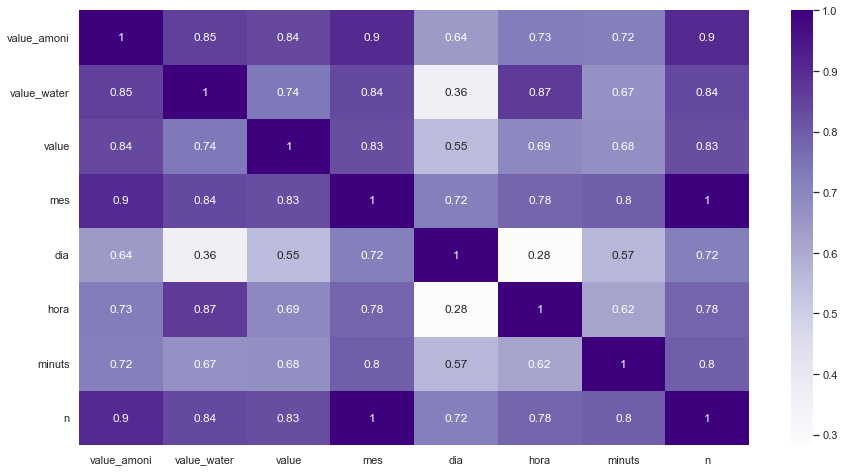

In [307]:

corrMatrix =result_nn.corr()
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(corrMatrix,annot=True,cmap="Purples")
plt.show()

<AxesSubplot:xlabel='row_date'>

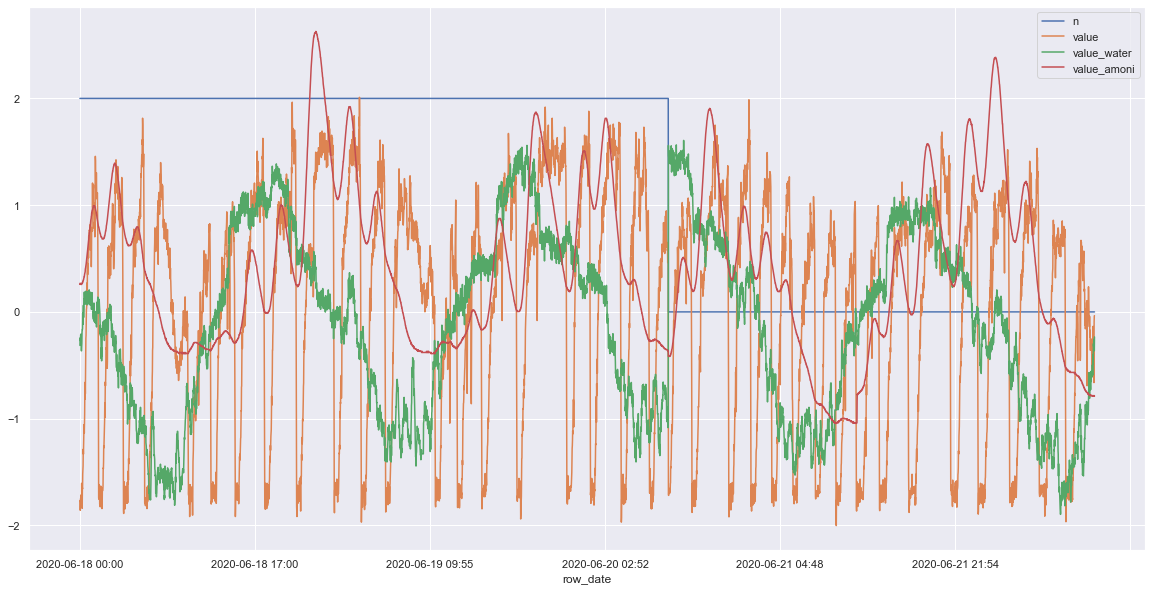

In [308]:
result[["n","value","value_water","value_amoni"]].plot(figsize=(20,10))

In [310]:
train_shuffle,test_shuffle = train_test_split(result,test_size =0.2,shuffle=True)

In [311]:
col = "n"
test_shuffle_X = test_shuffle.loc[:,test_shuffle.columns!=col]
test_shuffle_y = test_shuffle[[col]]
train_shuffle_X = train_shuffle.loc[:,train_shuffle.columns!=col]
train_shuffle_y = train_shuffle[[col]]

In [312]:
model_shuffle_clf = RandomForestClassifier(max_depth=2, random_state=0)
model_shuffle_clf.fit(train_shuffle_X, train_shuffle_y)

/tmp/ipykernel_3860/95353826.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_shuffle_clf.fit(train_shuffle_X, train_shuffle_y)


RandomForestClassifier(max_depth=2, random_state=0)

In [313]:
y_true = test_shuffle_y
y_predicted = model_shuffle_clf.predict(test_shuffle_X)
accuracy_score(y_true,y_predicted)

0.9362068965517242

/home/marc/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


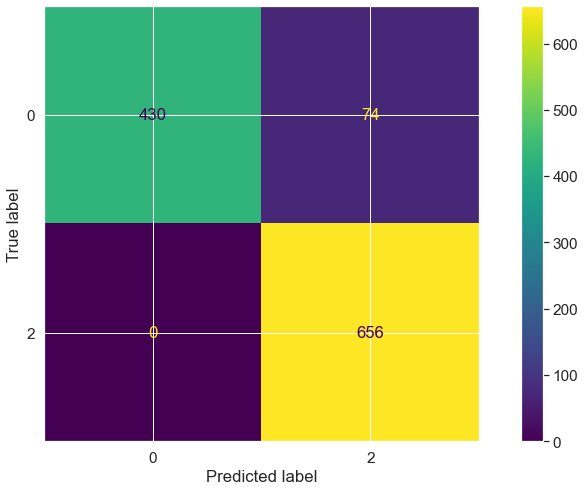

In [314]:
sn.set(font_scale=1.4)
plot_confusion_matrix(model_shuffle_clf,test_shuffle_X,test_shuffle_y)


In [315]:
train,test = train_test_split(result,test_size =0.2,shuffle=False)

In [316]:
col = "n"
test_X = test.loc[:,test.columns!=col]
test_y = test[[col]]
train_X = train.loc[:,train.columns!=col]
train_y = train[[col]]

In [317]:
model_clf = RandomForestClassifier(max_depth=2, random_state=0)
model_clf.fit(train_X, train_y)

/tmp/ipykernel_3860/1381926587.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_clf.fit(train_X, train_y)


RandomForestClassifier(max_depth=2, random_state=0)

In [318]:
y_true = test_y
y_predicted = model_clf.predict(test_X)
accuracy_score(y_true,y_predicted)

1.0

In [319]:
confusion_matrix(y_true,y_predicted)

array([[1160]])